# 1. Linear/Logistic Regression as A Single-layer Fully Connected Neural Network  [40pts]

# ![title](img/1.png)

We can think of linear/logistic regression as a single-layer fully connected neural network with different prediction head (SoftMax for logistic regression), as the input is $x_1$, $x_2$ to $x_d$ where $d$ is the input dimension, and a single computed neuron outputs a single numerical value $o_1$. We will first focus on the single-layer fully connected neural network for regression on the synthetic data in $1.1$ and for classification on MNIST dataset in $1.2$. In $1.3$, we will implement Multilayer Perceptrons (MLP) for classification on MNIST dataset.

## 1.1 Linear Neural Networks for regression


In [1]:
!pip install torch

In [2]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

### Task 1: Synthetic Data

We aim to synthesize data from the following linear model:

$\mathbf{y}=\mathbf{X} \mathbf{w}+b+\boldsymbol{\epsilon},$

where $\mathbf{X} \in \mathbb{R}^{n \times d}$, $\boldsymbol{\epsilon}\in\mathbb{R}^{n \times 1}$, $\mathbf{w}\in\mathbb{R}^{d \times 1}$ and $\mathbf{y}\in\mathbb{R}^{n \times 1}$. Sample $\mathbf{X}$ and $\boldsymbol{\epsilon}$ from normal distribution ( ${\mu=0,\sigma=1}$ for $\mathbf{X}$, ${\mu=0,\sigma=0.01}$ for $\boldsymbol{\epsilon}$ ). With your setted $\mathbf{w}$ and $b$, synthetic $y$ is also formed.

In [3]:

class SyntheticRegressionData(Dataset):
    def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000):
        super(SyntheticRegressionData, self).__init__()
        self.w = w
        self.b = b
        self.noise = noise
        self.num_train = num_train
        self.num_val = num_val
        self.total_samples = num_train + num_val
        self.prepare_data()

    def prepare_data(self):
        # sample X, noise using torch.randn
        ############ Answer here ############
        self.X = torch.randn(self.total_samples, len(self.w))
        noise = torch.randn(self.total_samples, 1) * self.noise
        #####################################

        # generate y using torch.randn torch.matmul
        #\mathbf{y}=\mathbf{X} \mathbf{w}+b+\boldsymbol{\epsilon}
        ############ Answer here ############
        self.y = torch.matmul(self.X, self.w) + self.b + noise
        #####################################

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

### Task 2: Formulate Linear Neural Networks Model

Complete the class `LinearRegression` with torch. Hint provided.

In [4]:
import torch.nn as nn
import torch.optim as optim

class LinearRegression(nn.Module):
    # define the learning rate, single-layer Linear Neural Networks `net` using linear layer in torch.nn. Default dimension: d=2
    def __init__(self, lr, input_dim=2):
        super(LinearRegression, self).__init__()
        ############ Answer here ############
        self.lr =  lr
        self.net = nn.Linear(input_dim, 1)
        #####################################
        self.init_weights()

    # using nn.init to initialize net.weight (normal_, mean=0, std=0.01) and net.bias (constant_, mean=0).
    def init_weights(self):
        ############ Answer here ############
        nn.init.normal_(self.net.weight, mean=0, std=0.01)
        nn.init.constant_(self.net.bias, 0)
        #####################################

    # define the forward funtion for forward propagation of `net`
    def forward(self, x):
        ############ Answer here ############
        return self.net(x)
        #####################################

    # define the MSE loss funtion for the regression task.
    def loss(self, y_hat, y):
        ############ Answer here ############
        criterion = nn.MSELoss()
        return criterion(y_hat, y)
        #####################################

    # define the SGD optimizer from torch for back propagation
    def optimizers(self):
        ############ Answer here ############
        return optim.SGD(self.parameters(), lr=self.lr)
        #####################################

### Task 3: Define the Trainer for Regression

Complete the class `Trainer_reg` with torch. Hint provided.

You will implement `__init__` to split the data and initialize the training setting, the training function `fit` for model training and `plot_losses` to plot `train_loss` and `val_loss` of each epoch.

In [5]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, random_split

class Trainer_reg:
    def __init__(self, model, data, max_epochs=3, batch_size=32, val_ratio=0.2,device='cpu'):
        # Initialize the model and training setting
        ############ Answer here ############
        self.model = model.to(device)
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.optimizer = model.optimizers()
        self.device= device
        #####################################

        # Split data into training and validation sets with the `val_ratio` and define the train_loader and val_loader using `DataLoader` with the `batch_size`
        ############ Answer here ############
        train_size = int((1 - val_ratio) * len(data))
        val_size = len(data) - train_size
        self.train_data, self.val_data = random_split(data, [train_size, val_size])
        self.train_loader = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=batch_size, shuffle=False)
        #####################################

        # To store the losses for plotting
        self.train_losses = []
        self.val_losses = []

    def fit(self):
        #define each training epoch
        for epoch in range(self.max_epochs):
            # set training mode
            ############ Answer here ############
            self.model.train()
            #####################################

            train_loss = 0
            # forward then back propagation for each batch
            for X, y in self.train_loader:
                if self.device == 'cuda' :
                        X, y = X.to('cuda'), y.to('cuda')
                else:
                        X, y = X.float(), y.float() #y.long()
                # forward propagation for prediction
                ############ Answer here ############
                y_hat = self.model(X)
                #####################################

                # loss computation
                ############ Answer here ############
                loss = self.model.loss(y_hat, y)
                #####################################

                # 3 steps for back propagation: (1) clear the gradient in the optimizer; (2) backward the loss to get the gradient of each parameter; (3) update the parameters using optimizer.
                ############ Answer here ############
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                #####################################

                train_loss += loss.item() * X.size(0)
            avg_train_loss = train_loss / len(self.train_data)

            # Validation phase
            # set evaluation model for model
            ############ Answer here ############
            self.model.eval()
            #####################################

            val_loss = 0
            # set torch with forwarding without gradient awareness
            ############ Answer here ############
            with torch.no_grad():
            #####################################
              for X, y in self.val_loader:
                if self.device == 'cuda' :
                        X, y = X.to('cuda'), y.to('cuda')
                else:
                        X, y = X.float(), y.float() #y.long()
                # forward propagation and compute loss for each batch
                    ############ Answer here ############
                y_hat = self.model(X)
                loss = self.model.loss(y_hat, y)
                    #####################################
                val_loss += loss.item() * X.size(0)
            avg_val_loss = val_loss / len(self.val_data)

            # Logging the losses
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)

            print(f'Epoch [{epoch + 1}/{self.max_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    def plot_losses(self):
        # plot `self.train_losses` and `self.val_losses` for all epochs
        ############ Answer here ############
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        #####################################

### Task 4: Train Your Model

Use your completed `LinearRegression`, `SyntheticRegressionData` and `Trainer` to implement the following cell.

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 2000])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([16, 2000])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/10], Train Loss: 22.3876, Val Loss: 17.2464
Epoch [2/10], Train Loss: 15.9947, Val Loss: 15.3148
Epoch [3/10], Train Loss: 15.1481, Val Loss: 15.0578
Epoch [4/10], Train Loss: 15.0355, Val Loss: 15.0235
Epoch [5/10], Train Loss: 15.0205, Val Loss: 15.0189
Epoch [6/10], Train Loss: 15.0185, Val Loss: 15.0183
Epoch [7/10], Train Loss: 15.0182, Val Loss: 15.0182
Epoch [8/10], Train Loss: 15.0182, Val Loss: 15.0182
Epoch [9/10], Train Loss: 15.0182, Val Loss: 15.0182
Epoch [10/10], Train Loss: 15.0182, Val Loss: 15.0182


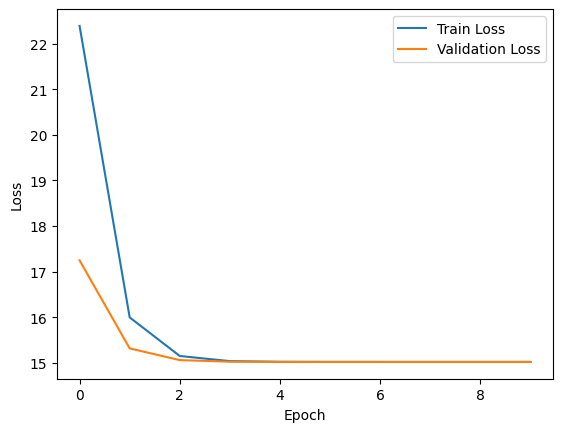

In [6]:
############ Answer here ############
# (1) Instantiate your model with your defined 'LinearRegression'
model = LinearRegression(lr=0.01, input_dim=2)
# (2) generate the synthetic data with your defined w and b
w = torch.tensor([2.0, -3.4])
b = torch.tensor([4.2])
data = SyntheticRegressionData(w, b)
# (3) Instantiate the trainer and fit your model
trainer = Trainer_reg(model, data, max_epochs=10, batch_size=32, device='cpu')
# (4) Start training
trainer.fit()
#####################################

# plot the loss
trainer.plot_losses()

## 1.2 Single-layer Neural Networks for classification

In this part, we will build a single-layer Neural Network for classification on MNIST dataset. THe differences are (1)additional SoftMax function is applied on the outputs, (2) Cross Entropy loss instead of MSE.


### Task 5: Formulate the Single-layer Neural Networks Model for Classification

Following Task 2, complete the following `SoftmaxRegression` class.

Hint: you can use F.softmax for SoftMax function and the input image need to be flattened before feeded into the linear layer.

In [7]:
import torch.nn.functional as F

class SoftmaxRegression(nn.Module):
    """The softmax regression model."""
    def __init__(self, num_outputs, lr):
        super(SoftmaxRegression, self).__init__()
        ############ Answer here ############
        self.lr = lr
        self.net = nn.Sequential(
           nn.Flatten(),   # Flatten the input tensor
           nn.Linear(28 * 28, num_outputs)   # linear layer to output logits
        )
        #####################################

    def forward(self, X):
        #forward propagation with softmax
        ############ Answer here ############
        logits = self.net(X)
        return F.softmax(logits, dim=1)
        #####################################

    # define the cross entropy loss funtion for the classification task.
    def loss(self, Y_hat, Y, averaged=True):
        ############ Answer here ############
        #####################################
        criterion = nn.CrossEntropyLoss()
        return criterion(Y_hat, Y)
        #####################################

    # define the SGD optimizer from torch for back propagation
    def optimizers(self):
        ############ Answer here ############
        return optim.SGD(self.parameters(), lr=self.lr)
        #####################################

### Task 6: Define the Trainer for Classification

Most of `Trainer_cls` is similar with the `Trainer_reg` in Task 3. For Task 6, you need additionally compute the validation accuracy in `Trainer_cls`

For Task 6, you need additionally compute the validation accuracy,  plot all epoches' `val_acc` with `train_loss` and `val_loss` in `plot_losses`.

In [8]:
import torch
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

class Trainer_cls:
    def __init__(self, model, data, max_epochs=3, batch_size=32, val_ratio=0.2,device='cpu'):
        ############ Answer here ############
        self.model = model.to(device)
        self.max_epochs = max_epochs
        self.batch_size = batch_size
        self.device = device
        self.optimizer = model.optimizers()

        # Split data into training and validation sets
        train_size = int((1 - val_ratio) * len(data))
        val_size = len(data) - train_size
        self.train_data, self.val_data = random_split(data, [train_size, val_size])
        self.train_loader = DataLoader(self.train_data, batch_size=batch_size, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=batch_size, shuffle=False)
        #####################################

        # To store the metrics for plotting
        self.train_losses = []
        self.val_losses = []
        self.val_acc = []  # To store validation accuracy

    def fit(self):
        for epoch in range(self.max_epochs):
            ############ Answer here ############
            # Validation phase should include validation accuracy
            self.model.train()
            train_loss = 0.0
            for X, Y in self.train_loader:
                X, Y = X.to(self.device), Y.to(self.device)
                # Forward pass
                Y_hat = self.model(X)
                loss = self.model.loss(Y_hat, Y)
                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * X.size(0)
            avg_train_loss = train_loss / len(self.train_loader.dataset)

            # Validation phase
            self.model.eval()
            val_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for X, Y in self.val_loader:
                    X, Y = X.to(self.device), Y.to(self.device)
                    Y_hat = self.model(X)
                    loss = self.model.loss(Y_hat, Y)
                    val_loss += loss.item() * X.size(0)
                    _, predicted = torch.max(Y_hat, 1)
                    total += Y.size(0)
                    correct += (predicted == Y).sum().item()
            avg_val_loss = val_loss / len(self.val_loader.dataset)
            #####################################
            val_accuracy = 100 * correct / total

            # Logging the metrics
            self.train_losses.append(avg_train_loss)
            self.val_losses.append(avg_val_loss)
            self.val_acc.append(val_accuracy)

            print(f'Epoch [{epoch + 1}/{self.max_epochs}]: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

    def plot_losses(self):
        # plot `self.train_losses`, `self.val_losses` and `self.val_acc` for all epochs
        ############ Answer here ############
        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.plot(self.val_acc, label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.legend()
        plt.show()
        #####################################

### Task 7: Train Your Model

Use your completed `SoftmaxRegression`, `Trainer_cls` to implement the following cell.


In [9]:
pip install torchvision

Epoch [1/10]: Train Loss: 1.8334, Val Loss: 1.7370, Val Acc: 76.05%
Epoch [2/10]: Train Loss: 1.7249, Val Loss: 1.7103, Val Acc: 77.91%
Epoch [3/10]: Train Loss: 1.7069, Val Loss: 1.6982, Val Acc: 78.70%
Epoch [4/10]: Train Loss: 1.6971, Val Loss: 1.6908, Val Acc: 79.25%
Epoch [5/10]: Train Loss: 1.6904, Val Loss: 1.6860, Val Acc: 79.59%
Epoch [6/10]: Train Loss: 1.6859, Val Loss: 1.6811, Val Acc: 79.81%
Epoch [7/10]: Train Loss: 1.6822, Val Loss: 1.6783, Val Acc: 80.05%
Epoch [8/10]: Train Loss: 1.6790, Val Loss: 1.6749, Val Acc: 80.20%
Epoch [9/10]: Train Loss: 1.6764, Val Loss: 1.6733, Val Acc: 80.33%
Epoch [10/10]: Train Loss: 1.6742, Val Loss: 1.6706, Val Acc: 80.56%


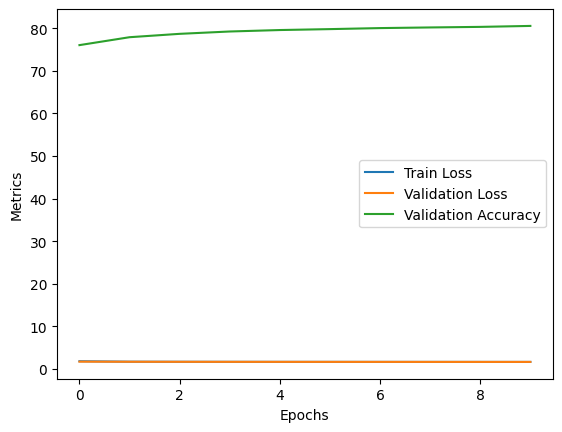

In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

############ Answer here ############
# (1) Load the full Fashion MNIST dataset with torchvision.datasets
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
MNISTdataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# (2) Define batch size and instantiate the model
batch_size = 256
model = SoftmaxRegression(num_outputs=10, lr=0.1)

# (3) Instantiate the trainer with the full dataset (Trainer will handle splitting)
trainer = Trainer_cls(model, MNISTdataset, max_epochs=10, batch_size=batch_size, device='cpu')

# (4) Start training
trainer.fit()
#####################################

# (5)plot the losses and accuracies
trainer.plot_losses()



#  2. Multilayer Perceptrons for Classification [20pts]

Since focusing on the same task of 1.2, you only need to complete the `MLP` model class as following task and use the same `Trainer_cls` in 1.2.

### Task 8: Build 3-layer Multilayer Perceptrons (MLP) for classification on MNIST dataset

Complete the class `MLP` with torch. The architecture of the MLP to be built is 3-layer with ReLU as the activation function. And there is a dropout layer for after layer 1/layer 2's activation. Most of implementations are similar with those in Task 5 except the model architecture.

Hint: define the net in nn.Sequential similar with above task with the proper layer arrangement.

In [11]:
import torch.nn.functional as F

class MLP(nn.Module):
    """The softmax regression model."""
    def __init__(self, num_outputs,num_hiddens1,num_hiddens2,dropout_rate, lr):
        super(MLP, self).__init__()
        ############ Answer here ############
        self.lr = lr
        # Flatten -> linear -> ReLU -> Dropout -> linear -> ReLU -> Dropout -> linear
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, num_hiddens1),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(num_hiddens1, num_hiddens2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(num_hiddens2, num_outputs)
        )
        #####################################

    # similar with  task 5
    def forward(self, X):
        ############ Answer here ############
        return self.net(X)
        #####################################

    # similar with  task 5
    def loss(self, Y_hat, Y, averaged=True):
        ############ Answer here ############
        criterion = nn.CrossEntropyLoss()
        return criterion(Y_hat, Y)
        #####################################

    # similar with  task 5
    def optimizers(self):
        ############ Answer here ############
        return optim.SGD(self.parameters(), lr=self.lr)
        #####################################

### Task 9: Train Your Model

Use your completed `MLP`, `Trainer_cls` in Task 6 to implement the following cell.

Epoch [1/10]: Train Loss: 1.1372, Val Loss: 0.6435, Val Acc: 75.54%
Epoch [2/10]: Train Loss: 0.7212, Val Loss: 0.5526, Val Acc: 78.26%
Epoch [3/10]: Train Loss: 0.6357, Val Loss: 0.4955, Val Acc: 81.97%
Epoch [4/10]: Train Loss: 0.5887, Val Loss: 0.4781, Val Acc: 82.48%
Epoch [5/10]: Train Loss: 0.5578, Val Loss: 0.4599, Val Acc: 83.67%
Epoch [6/10]: Train Loss: 0.5341, Val Loss: 0.4471, Val Acc: 83.65%
Epoch [7/10]: Train Loss: 0.5200, Val Loss: 0.4353, Val Acc: 84.17%
Epoch [8/10]: Train Loss: 0.5041, Val Loss: 0.4405, Val Acc: 83.73%
Epoch [9/10]: Train Loss: 0.4906, Val Loss: 0.4193, Val Acc: 84.77%
Epoch [10/10]: Train Loss: 0.4829, Val Loss: 0.4205, Val Acc: 84.43%


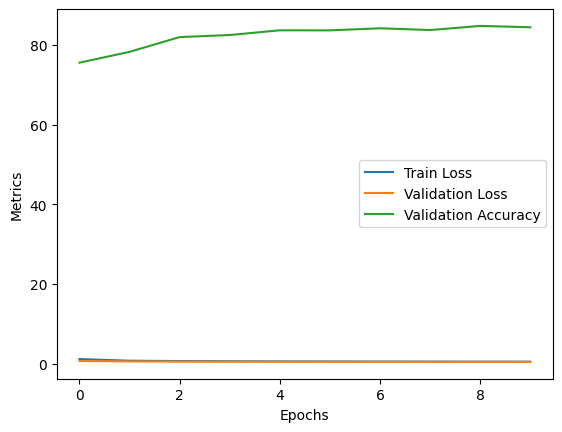

In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Use the full Fashion MNIST dataset from Task 7
MNISTdataset = MNISTdataset

############ Answer here ############
# (1) Define batch size and instantiate the MLP model with your selected hyperparameters.
batch_size = 256
model = MLP(num_outputs=10, num_hiddens1=128, num_hiddens2=64, dropout_rate=0.5, lr=0.1)

# (2) Instantiate the trainer with the full dataset (Trainer will handle splitting)
trainer = Trainer_cls(model, MNISTdataset, max_epochs=10, batch_size=batch_size, device='cpu')

# (3) Start training
trainer.fit()
#####################################

# (4)plot the losses and accuracies
# should have better performance than single-layer neural network classifier
trainer.plot_losses()

#  3. Convolutional Neural Networks

## 3.1 Implement the 2-dimensional Convolutional Operator [10pts]

Here, we are going to implement the 2-dimensional convolutional operator with padding and stride from the scratch.

Check the slides in class or this [link](https://medium.com/@Tms43/understanding-padding-strides-in-convolutional-neural-networks-cnn-for-effective-image-feature-1b0756a52918) for understanding.

### Task 10: Complete the following `corr2d` function as the 2-dimensional convolutional operator with padding and stride.

Hint are given in comments. Any implemented conv2d functions from torch/tensorflow/Jax are not allowed.

In [13]:
# X is the input image and K is the kernel for convolutional operator
def corr2d(X0, K, stride=1, padding=0):
    # (1) Add padding to the height and width of the image to get the X with padding, you can use torch.nn.functional.pad.
    ############ Answer here ############
    if padding > 0:
        X = torch.nn.functional.pad(X0, (padding, padding, padding, padding))
    else:
        X = X0
    #####################################

    # (2) Compute the height and width of Y after convolution given stride, padding size and kernel shape.
    h, w = K.shape
    ############ Answer here ############
    Y_h = (X.shape[0] - h) // stride + 1
    Y_w = (X.shape[1] - w) // stride + 1
    #####################################
    Y = torch.zeros((Y_h, Y_w))

    # (3) compute the value for each pixel of Y
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            ############ Answer here ############
            x_start = i * stride
            y_start = j * stride
            Y[i, j] = (X[x_start:x_start + h, y_start:y_start + w] * K).sum()
            #####################################
    return Y

Run the following code to check your implementation of corr2d, the result should be:

tensor([[19., 25.],
        [37., 43.]])
tensor([[ 0.,  3.,  8.,  4.],
        [ 9., 19., 25., 10.],
        [21., 37., 43., 16.],
        [ 6.,  7.,  8.,  0.]])
tensor([[ 0.,  8.],
        [21., 43.]])
tensor([[0., 4.],
        [6., 0.]])
tensor([[0.]])

In [14]:
# Check your result here, help you adjust your corr2d implementation
X = torch.tensor([[0.0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
K = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
print(corr2d(X, K, stride=1, padding=0))
print(corr2d(X, K, stride=1, padding=1))
print(corr2d(X, K, stride=2, padding=1))
print(corr2d(X, K, stride=3, padding=1))
print(corr2d(X, K, stride=4, padding=1))

tensor([[19., 25.],
        [37., 43.]])
tensor([[ 0.,  3.,  8.,  4.],
        [ 9., 19., 25., 10.],
        [21., 37., 43., 16.],
        [ 6.,  7.,  8.,  0.]])
tensor([[ 0.,  8.],
        [21., 43.]])
tensor([[0., 4.],
        [6., 0.]])
tensor([[0.]])


## 3.2 Learn the kernel [10pts]

The kernel `K` in `corr2d` is the above is the target to be learnt for Convolutional Neural Networks. In Task 11, we will show it in a simple example.

We first build a toy image with shape (8,6), where row 1-3, 6-8 are white and row 4-5 are black.

In [15]:
X = torch.ones((8, 6))
X[3:5,] = 0
X

tensor([[1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1.]])

Then, we handcraft a kernel `K` as a horizontal edge detector. `corr2d(X, K)` gives the output as：

In [16]:
K = torch.tensor([[1.0], [-1.0]])
Y = corr2d(X, K)
Y

tensor([[ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  1.,  1.,  1.,  1.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [-1., -1., -1., -1., -1., -1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.]])

If we transpose the image, `corr2d(X, K)` will output:

In [17]:
corr2d(X.t(), K)

tensor([[0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.]])

It indicates that kernel `K = torch.tensor([[1.0], [-1.0]])` can only detect horizontal edges not vertical ones.

Further, we can treat the `K` as an unknown kernel to learn. `K` is a kenerl in the convolution operation that leads to horizontal edge awareness.

Thus, to learn the unknown `K` given above `X` and `Y`, we can treat `K` as the weight of a single-layer neural network but in the manner of convolution operation to perform forward propagation.

### Task 11: A simple Conv2D model
In the following, build a simple Conv2D model class `Conv2D` without bias term for learning the horizontal edge detector kernel `K`.

In [18]:
class Conv2D(nn.Module):
    def __init__(self, kernel_size,stride=1, padding=0):
        super().__init__()
        # (1) define the weight using nn.Parameter to parameterize K, define stride and padding.
        ############ Answer here ############
        self.weight = nn.Parameter(torch.randn(kernel_size))
        self.stride = stride
        self.padding = padding
        #####################################

    def forward(self, x):
        # (2) forward propagation of x with parameterized kernel self.weight in the manner of corr2d
        ############ Answer here ############
        return corr2d(x, self.weight, stride=self.stride, padding=self.padding)
        #####################################

### Task 12: fitting the simple Conv2D model to find the horizontal edge detector kernel


In [19]:
# (1) Instantiate your model with your defined 'Conv2D'
############ Answer here ############
conv2d = Conv2D(kernel_size=(2, 1), stride=1, padding=0)
#####################################
lr = 1e-2  # Learning rate

# (2) Training
for i in range(100):
    ############ Answer here ############
    # forward propagation
    Y_hat = conv2d(X)
    # squared loss computation
    l = ((Y_hat - Y) ** 2).sum()
    # clear gradient and back propagation to get the gradient
    conv2d.zero_grad()
    l.backward()
    # update the kernel
    conv2d.weight.data[:] -= lr * conv2d.weight.grad
    #####################################

    if (i + 1) % 2 == 0:
        print(f'epoch {i + 1}, loss {l.sum():.3f}')

epoch 2, loss 0.101
epoch 4, loss 0.059
epoch 6, loss 0.036
epoch 8, loss 0.021
epoch 10, loss 0.013
epoch 12, loss 0.008
epoch 14, loss 0.005
epoch 16, loss 0.003
epoch 18, loss 0.002
epoch 20, loss 0.001
epoch 22, loss 0.001
epoch 24, loss 0.000
epoch 26, loss 0.000
epoch 28, loss 0.000
epoch 30, loss 0.000
epoch 32, loss 0.000
epoch 34, loss 0.000
epoch 36, loss 0.000
epoch 38, loss 0.000
epoch 40, loss 0.000
epoch 42, loss 0.000
epoch 44, loss 0.000
epoch 46, loss 0.000
epoch 48, loss 0.000
epoch 50, loss 0.000
epoch 52, loss 0.000
epoch 54, loss 0.000
epoch 56, loss 0.000
epoch 58, loss 0.000
epoch 60, loss 0.000
epoch 62, loss 0.000
epoch 64, loss 0.000
epoch 66, loss 0.000
epoch 68, loss 0.000
epoch 70, loss 0.000
epoch 72, loss 0.000
epoch 74, loss 0.000
epoch 76, loss 0.000
epoch 78, loss 0.000
epoch 80, loss 0.000
epoch 82, loss 0.000
epoch 84, loss 0.000
epoch 86, loss 0.000
epoch 88, loss 0.000
epoch 90, loss 0.000
epoch 92, loss 0.000
epoch 94, loss 0.000
epoch 96, loss 0.

Check your result by running following cell. It should be very closed to `tensor([[ 1.0000],[-1.0000]])`.

In [20]:
conv2d.weight.data.reshape((2, 1))


tensor([[ 1.0000],
        [-1.0000]])

## 3.3 Implement modern Convolutional Neural Networks ResNet18 for classification [20pts]

In 3.3, you will implement [ResNet18](https://arxiv.org/pdf/1512.03385) a Convolutional Neural Network with Residual blocks.

We will implement the 18-layer version of ResNet. The architecture of ResNet18 is in following tabel (Tabel 1 of [paper](https://arxiv.org/pdf/1512.03385)):

# ![title](img/3.png)

We can find that ResNet18 has 6 modules. The first module is made of a convolutional layer, a batch normal layer and a max pooling layer. The 4 middle residual modules have different channel number 64, 128, 256, 512. Each residual module is made of two residual blocks. A residual block looks like this:

# ![title](img/2.png)


The 1x1 conv (right one) only applies to the first residual block of the 2nd, 3rd and 4th middle residual modules. The other (2 residual blocks of 1st middle residual module, 2nd residual blocks of the other middle residual modules) residual blocks are the left one.

After the first module and 4 residual modules, the last module includes an average pooling layer and full connected linear layer for prediction.

### Task 13: Implement ResNet18

In following, you will need complete `Residual` class to define a general residual block to formulate each residual module. And complete 6 modules in `ResNet` class (mainly 1st and last module, the residual modules are based on your `Residual` class). After it, you need to complete the `optimizers` and `loss` in `ResNet18` class.


In [21]:
import torch
import torch.nn as nn

class Residual(nn.Module):
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super(Residual, self).__init__()
        #recommend LazyConv2d for easier implementation
        ############ Answer here ############
        # the first convolutional layer has kernel_size 3, padding 1. If it is the first residual block of the 2nd, 3rd and 4th middle residual modules, the stride is 2 (1 otherwise).
        # You may set the stride=strides as the stride value for the first convolutional layer of the residual block may vary. We can adjust it by control stride in the ResNet class,
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=strides)
        # the second convolutional layer has kernel_size 3, padding 1, stride 1.
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1, stride=1)
        #####################################

        ############ Answer here ############
        if use_1x1conv:
            # 1x1 conv residual connection (kernel_size 1, stride is 2) for the first residual block of the 2nd, 3rd and 4th middle residual modules.
            # You may set the stride=strides
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1, stride=strides)
        else:
            # identity residual connection for other cases
            self.conv3 = nn.Identity()
        #####################################

        # define 2 batch norm layers in the residual block using LazyBatchNorm2d
        ############ Answer here ############
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()
        #####################################

    def forward(self, x):
        ############ Answer here ############
        # conv1 -> BN1 -> ReLU -> conv -> BN2 -> Y
        y = nn.functional.relu(self.bn1(self.conv1(x)))
        y = self.bn2(self.conv2(y))
        # Residual term
        residual = x
        if self.conv3:
            residual = self.conv3(x)
        # Y + residual term
        y += residual
        # ReLU activation for the final output
        return nn.functional.relu(y)
        #####################################

class ResNet(nn.Module):
    def __init__(self, arch, num_classes=10):
        super(ResNet, self).__init__()
        self.net = nn.Sequential()
        # complete self.net.add_module('b1',)
        # use nn.Sequential to construct the 1st('b1') module
        # conv (padding 3) -> BN -> ReLU -> Max Pooling (padding 1)
        # check the above tabel and paper for other hyperparameters
        ############ Answer here ############
        self.net.add_module('b1', nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        ))
        #####################################

        for i, (num_residuals, num_channels) in enumerate(arch):
            self.net.add_module(f'b{i+2}', self.block(num_residuals, num_channels, first_block=(i==0)))

        # complete self.net.add_module('last',)
        # use nn.Sequential to construct the 'last' module
        # AdaptiveAvgPool2d (1,1) -> Flatten -> Linear (input dimension: 512, output dimension: num_classes)
        ############ Answer here ############
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, num_classes)
        ))
        #####################################

        self.net.apply(self.init_cnn)

    def block(self, num_residuals, num_channels, first_block=False):
        layers = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                layers.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                layers.append(Residual(num_channels))
        return nn.Sequential(*layers)

    def init_cnn(self,module):
        if type(module) == nn.Linear or type(module) == nn.Conv2d:
            nn.init.xavier_uniform_(module.weight)

    def forward(self, x):
        # forward propagation
        ############ Answer here ############
        return self.net(x)
        #####################################

class ResNet18(ResNet):
    def __init__(self, num_classes=10,lr=0.1):
        super(ResNet18, self).__init__(((2, 64), (2, 128), (2, 256), (2, 512)), num_classes)
        self.lr=lr

    def optimizers(self):
        # define the SGD optimizers
        ############ Answer here ############
        return optim.SGD(self.parameters(), lr=self.lr)
        #####################################

    def loss(self, Y_hat, Y, averaged=True):
        # define the cross_entropy loss for classification
        ############ Answer here ############
        criterion = nn.CrossEntropyLoss()
        return criterion(Y_hat, Y)
        #####################################


Epoch [1/10]: Train Loss: 0.4776, Val Loss: 0.3825, Val Acc: 86.07%
Epoch [2/10]: Train Loss: 0.2759, Val Loss: 0.3538, Val Acc: 87.25%
Epoch [3/10]: Train Loss: 0.2143, Val Loss: 0.2757, Val Acc: 89.83%
Epoch [4/10]: Train Loss: 0.1659, Val Loss: 0.2527, Val Acc: 90.97%
Epoch [5/10]: Train Loss: 0.1258, Val Loss: 0.3703, Val Acc: 87.62%
Epoch [6/10]: Train Loss: 0.0907, Val Loss: 0.2953, Val Acc: 89.94%
Epoch [7/10]: Train Loss: 0.0690, Val Loss: 0.3148, Val Acc: 90.50%
Epoch [8/10]: Train Loss: 0.0426, Val Loss: 0.2977, Val Acc: 90.89%
Epoch [9/10]: Train Loss: 0.0256, Val Loss: 0.3781, Val Acc: 90.04%
Epoch [10/10]: Train Loss: 0.0113, Val Loss: 0.2968, Val Acc: 91.96%


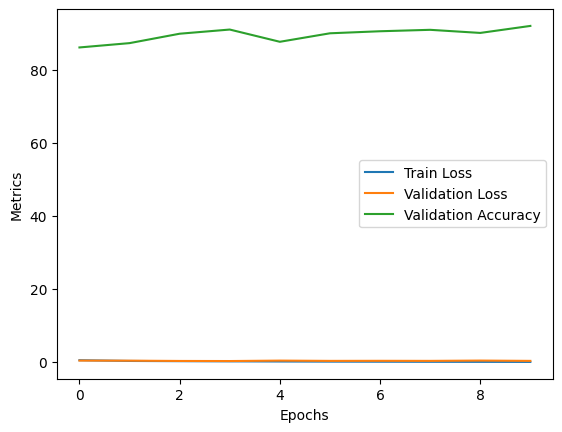

In [22]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
############ Answer here ############
# (1) add resize image to (96, 96) into the transform
# Load the full Fashion MNIST dataset with torchvision
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
MNISTdataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# (2) Define batch size and instantiate the ResNet18 model with lr=0.01
# set the model to GPU
batch_size = 256
model = ResNet18(num_classes=10, lr=0.01).to('cuda')

# (3) Instantiate the trainer with the full dataset (Trainer will handle splitting)
# set device to cuda to have faster training
trainer = Trainer_cls(model, MNISTdataset, max_epochs=10, batch_size=batch_size, device='cuda')

# (4) Start training
trainer.fit()
#####################################

# (5)plot the losses and accuracies
# should have better performance than single-layer neural network classifier
trainer.plot_losses()